# Radar & AI for Human Computer Interaction via Hand Gestures

## 1st Classification Method: Chebyshev moments

**Imports:**

In [1]:
# Import Libraries
import glob
import os
import pickle
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
import scipy.ndimage
import seaborn as sn
from scipy.special import comb, factorial


from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.svm import SVC, SVR


from tensorflow.keras.layers import Conv1D, Dense, Dropout, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

**Configuration:**

In [ ]:
#Download Github data from: 'https://figshare.com/ndownloader/files/45297967?private_link=e2d70817514f8e40e400'

# ---  SET YOUR DATA PATH HERE !!!!! ---
base_path = "/Users/beno/Desktop/TU DELFT/ML for EE/Gesture Data/Training Data" 
test_path = "/Users/beno/Desktop/TU DELFT/ML for EE/Gesture Data/Test Data"

# ---  SET MOMENT ORDER (for Chebyshev method) ---
MAX_MOMENT_ORDER = 20  #According to the paper, 20 is the best-performing.


# ---  GESTURE MAPPING ---

# 'Wave'=1, 'Pinch'=2, 'Swipe'=3, 'Click'=4
gestures = {1: 'Wave', 2: 'Pinch', 3: 'Swipe', 4: 'Click'}

# Labels for the model (0, 1, 2, 3)
gesture_map_labels = {'Wave': 0, 'Pinch': 1, 'Swipe': 2, 'Click': 3}
num_classes = 4

# Check if the path exists:
if not os.path.isdir(base_path):
    print(f"Error: Directory not found at '{base_path}'")
else:
    print(f"Data directory set to: {base_path}")

Data directory set to: /Users/beno/Desktop/TU DELFT/ML for EE/Gesture Data/Training Data


**Chebyshev Math functions:**

In [3]:
def discrete_chebyshev_poly(l, x, L):
    """
    Computes the discrete Chebyshev polynomial t_l(x) of order l for
    a size L, evaluated at x.
    Based on Equation (2).
    """
    s = 0
    fact_l = factorial(l, exact=True)
    for k in range(l + 1):
        term1 = (-1)**(l - k)
        term2 = comb(L - 1 - k, l - k, exact=True)
        term3 = comb(l + k, l, exact=True)
        term4 = comb(x, k, exact=True)
        s += term1 * term2 * term3 * term4
    return fact_l * s

def precompute_scaled_polys(max_order, L):
    """
    Precomputes the scaled discrete Chebyshev polynomials.
    Based on Equations (5) and (6).
    Returns a matrix T[l, x] of shape (max_order + 1, L).
    """
    T = np.zeros((max_order + 1, L))
    for l in range(max_order + 1):
        beta_val = L**l
        if beta_val == 0:
            if l == 0:
                beta_val = 1.0 # \beta(0, L) = L^0 = 1
            else:
                continue 
        
        for x in range(L):
            T[l, x] = discrete_chebyshev_poly(l, x, L) / beta_val
    return T

def precompute_scaled_norm(max_order, L):
    """
    Precomputes the squared norm of the scaled polynomials.
    Based on Equations (3),(4),(5),(6).
    Returns a vector R[l] of shape (max_order + 1,).
    """
    R = np.zeros(max_order + 1)
    for l in range(max_order + 1):
        if L-1 < l:
            continue
            
        try:
            rho_val = factorial(2 * l, exact=True) * comb(L + l, 2 * l + 1, exact=True)
        except ValueError:
            rho_val = 0 
        
        beta_val_sq = (L**l)**2
        
        if beta_val_sq == 0:
             if l == 0:
                beta_val_sq = 1.0
             else:
                continue
                
        R[l] = rho_val / beta_val_sq
    
    R[R == 0] = 1.0 #avoiding division by zero
    return R

**Feature Extraction Function:**

In [4]:
def extract_chebyshev_features(cvd_modulus_image, max_order, T_L_pre, T_H_pre, R_L_pre, R_H_pre):
    """
    Extracts the Chebyshev moments as a 1D feature vector.
    Implements Equation (10) and (11).
    """
    L, H = cvd_modulus_image.shape
    
    if T_L_pre.shape[1] != L or T_H_pre.shape[1] != H:
        raise ValueError("Precomputed polynomial sizes do not match image dimensions")

    M = T_L_pre @ cvd_modulus_image @ T_H_pre.T
    
    # Norms = R_L[:, None] @ R_H[None, :]
    Norms = R_L_pre[:, None] @ R_H_pre[None, :]
    Norms[Norms == 0] = 1.0 # Avoid division by zero
    
    # Element-wise division for normalized moments T_{l,h}
    T_moments = M / Norms

    # Flatten into feature vector F
    # We only take moments where l + h <= max_order
    F = []
    for l in range(max_order + 1):
        for h in range(max_order + 1):
            if l + h <= max_order:
                F.append(T_moments[l, h])
                
    return np.array(F)

**Training Data Loading Function:**

In [5]:
def load_all_data(data_dir, gesture_map):
    """
    Loads all training files from the specified directory.
    """
    X_all = [] # List to hold all spectrograms
    y_all = [] # List to hold all labels (0, 1, 2, 3)
    
    # Find all training data files
    mat_files = glob.glob(os.path.join(data_dir, 'Data_Per_PersonData_Training_Person_*.mat'))
    
    if not mat_files:
        print(f"Warning: No .mat files found matching 'Data_Training_Person_*.mat' in {data_dir}")
        return [], []
        
    print(f"Found {len(mat_files)} person files...")
    
    for mat_file in mat_files:
        print(f"Loading data from {os.path.basename(mat_file)}...")
        
        data = scipy.io.loadmat(mat_file)
        doppler_signals = data['Data_Training']['Doppler_Signals'][0, 0]
        num_gestures = doppler_signals.shape[1]  
        
        for gesture_idx in range(num_gestures): # This will loop 0, 1, 2, 3
            # Matlab index is 1-based
            gesture_name = gesture_map.get(gesture_idx + 1, 'Unknown')
            label = gesture_map_labels[gesture_name]
            repeats = doppler_signals[0, gesture_idx]
            
            for repeat_idx in range(len(repeats)): 
                x = repeats[repeat_idx, 0]
                
                X_all.append(x)
                y_all.append(label)
                
    print(f"Loaded {len(X_all)} total samples from {len(mat_files)} files.")
    return X_all, y_all

**Test Data Loading Function:**

In [6]:
def load_test_data(test_file_path):
    """
    Loads the test data from the 'Data_For_Test_Random.mat' file.
    """
    
    X_test = []
    y_test = []
    
    if not os.path.exists(test_file_path):
        print(f"Error: Test file not found at '{test_file_path}'")
        return [], []
        
    print(f"Loading test data from {test_file_path}...")
    data = scipy.io.loadmat(test_file_path)
    data_rand = data['Data_rand']
    
    num_samples = data_rand.shape[0]
    
    for idx in range(num_samples):
        try:
            
            # matching sample code of Github: test["Data_rand"][...][0][0][0]
            x = data_rand[idx, 0][0][0]
            y_string = data_rand[idx, 1][0]
            
            # Splitting the string by spaces and taking the first word
            gesture_name = y_string.split(' ')[0]
            
            # Mapping the words to the label numbers
            if gesture_name in gesture_map_labels:
                y = gesture_map_labels[gesture_name]
            else:
                print(f"Warning: Unknown gesture '{gesture_name}' in test sample {idx}. Skipping.")
                continue
                
                
            X_test.append(x)
            y_test.append(y)
            
        except Exception as e:
            print(f"Error processing test sample {idx}: {e}")
            
    print(f"Loaded {len(X_test)} total test samples.")
    return X_test, np.array(y_test)

**Feature extraction pipeline function**

In [7]:
def preprocess_and_extract_features(X_data, max_moment_order, target_size=None):
    """
    Applies the full feature extraction pipeline (CVD + Chebyshev).
    
    If 'target_size' is None, it's calculated from the first training sample.
    If 'target_size' is provided, all samples are resized to that size.
    
    Returns: (features, target_size)
    """
    
    if target_size is None:
        # --- Determine target size from first sample ---
        X_stft_mod = np.abs(X_data[0])
        X_cvd = np.fft.fft(X_stft_mod, axis=1) 
        X_cvd_mod = np.abs(X_cvd)
        TARGET_L, TARGET_H = X_cvd_mod.shape
        print(f"Target CVD image size set to: L={TARGET_L}, H={TARGET_H}")
    else:
        # --- Use provided target size ---
        TARGET_L, TARGET_H = target_size
        print(f"Using provided target size: L={TARGET_L}, H={TARGET_H}")
    
    print("Precomputing Chebyshev polynomials and norms...")
    T_L_pre = precompute_scaled_polys(max_moment_order, TARGET_L)
    T_H_pre = precompute_scaled_polys(max_moment_order, TARGET_H)
    R_L_pre = precompute_scaled_norm(max_moment_order, TARGET_L)
    R_H_pre = precompute_scaled_norm(max_moment_order, TARGET_H)
    print("Precomputation complete.")
    
    # --- Process all samples ---
    F_all = []
    
    for i, x in enumerate(X_data):
        X_stft_mod = np.abs(x)
        X_cvd = np.fft.fft(X_stft_mod, axis=1)
        X_cvd_mod = np.abs(X_cvd)
        
        # --- Check and resize if necessary ---
        L_current, H_current = X_cvd_mod.shape
        if L_current != TARGET_L or H_current != TARGET_H:
            zoom_L = TARGET_L / L_current
            zoom_H = TARGET_H / H_current
            # Use order=1 (bilinear) for interpolation, order=0 (nearest) is faster
            X_cvd_mod = scipy.ndimage.zoom(X_cvd_mod, (zoom_L, zoom_H), order=1)


        # Extract Chebyshev features
        F = extract_chebyshev_features(X_cvd_mod, max_moment_order, T_L_pre, T_H_pre, R_L_pre, R_H_pre)
        F_all.append(F)
        
    return np.array(F_all), (TARGET_L, TARGET_H)

**Load Training Data:**

In [8]:
X_data, y_data = load_all_data(base_path, gestures)
y_data = np.array(y_data)

if len(X_data) == 0:
    print("Data loading failed. Please check your DATA_DIRECTORY path and file names.")
else:
    print(f"Successfully loaded {len(X_data)} samples.")

Found 6 person files...
Loading data from Data_Per_PersonData_Training_Person_B.mat...
Loading data from Data_Per_PersonData_Training_Person_C.mat...
Loading data from Data_Per_PersonData_Training_Person_A.mat...
Loading data from Data_Per_PersonData_Training_Person_D.mat...
Loading data from Data_Per_PersonData_Training_Person_E.mat...
Loading data from Data_Per_PersonData_Training_Person_F.mat...
Loaded 2433 total samples from 6 files.
Successfully loaded 2433 samples.


**Load Test Data:**

In [9]:
test_file_path = os.path.abspath(os.path.join(test_path, 'Data_For_Test_Random.mat'))
X_test_data, y_test_data = load_test_data(test_file_path)

if len(X_test_data) == 0:
    print("Error:Test data loading failed.")

Loading test data from /Users/beno/Desktop/TU DELFT/ML for EE/Gesture Data/Test Data/Data_For_Test_Random.mat...
Loaded 643 total test samples.


**Extract Training Data Features:**

In [10]:
# Extract features and get the target_size from the training data
F_features_train, target_size = preprocess_and_extract_features(X_data, MAX_MOMENT_ORDER)
print(f"Training feature extraction complete. Feature vector shape: {F_features_train.shape}")

Target CVD image size set to: L=800, H=136
Precomputing Chebyshev polynomials and norms...
Precomputation complete.
Training feature extraction complete. Feature vector shape: (2433, 231)


**Extract Test Data Features:**

In [11]:
# Extract test features using the same target_size as training data
print("Extracting test features...")
F_features_test, _ = preprocess_and_extract_features(X_test_data, MAX_MOMENT_ORDER, target_size=target_size)
print(f"Test feature extraction complete. Feature vector shape: {F_features_test.shape}")

Extracting test features...
Using provided target size: L=800, H=136
Precomputing Chebyshev polynomials and norms...
Precomputation complete.
Test feature extraction complete. Feature vector shape: (643, 231)


**Prepare data for classifier:**

In [12]:
# Assign the loaded training and test sets
X_train = F_features_train
y_train = y_data
X_test = F_features_test
y_test = y_test_data

# Normalize features (z-score)
# Fit the scaler on the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
# Transform the test data using the scaler fitted on training data
X_test_scaled = scaler.transform(X_test)

# One-hot encode labels for the CNN
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(f"Training features shape: {X_train_scaled.shape}")
print(f"Test features shape:     {X_test_scaled.shape}")

Training features shape: (2433, 231)
Test features shape:     (643, 231)


## CNN (1D):

**1D CNN Model Definition:**

In [13]:
def build_cnn_model(input_shape, num_classes):
    """
    Builds a 1D CNN model to classify the feature vectors.
    """
    model = Sequential()
    # Input shape is (num_features, 1)
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.4))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    return model

**Build, Train, and Evaluate CNN**

CNN input shape: (2433, 231, 1)


/Users/beno/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 229, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 227, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 113, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 113, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 111, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 109, 128)       │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,620 (404.77 KB)

 Trainable params: 103,620 (404.77 KB)

 Non-trainable params: 0 (0.00 B)


Training CNN model...


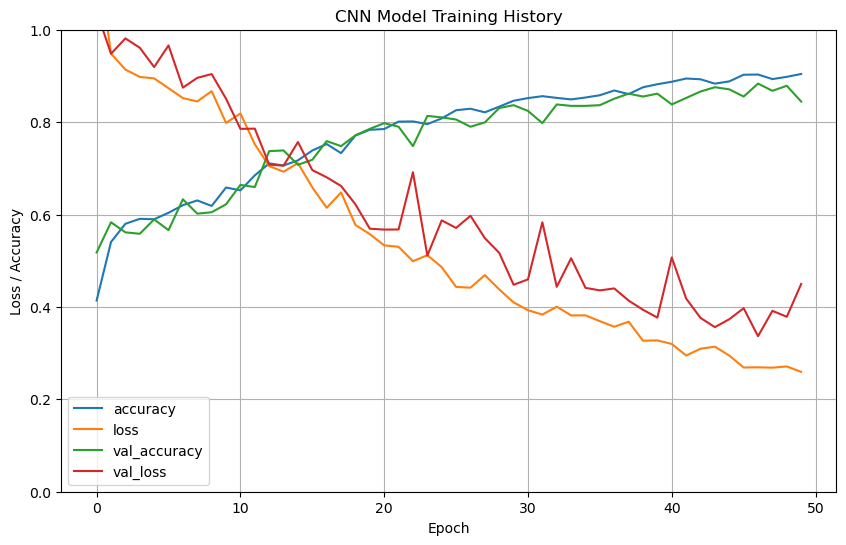


Evaluating CNN model...
Test Accuracy (CNN): 84.45%


In [14]:
# ---  Prepare for 1D CNN ---
# A 1D CNN expects input as (batch_size, steps, channels)
num_features = X_train_scaled.shape[1]
X_train_cnn = np.expand_dims(X_train_scaled, axis=-1)
X_test_cnn = np.expand_dims(X_test_scaled, axis=-1)

print(f"CNN input shape: {X_train_cnn.shape}")

# --- Build and Train CNN Model ---
cnn_model = build_cnn_model(input_shape=(num_features, 1), num_classes=num_classes)
cnn_model.summary() 

print("\nTraining CNN model...")
history = cnn_model.fit(
    X_train_cnn, y_train_cat,
    epochs=50, #Trying with 50 epochs
    batch_size=32,
    validation_data=(X_test_cnn, y_test_cat),
    verbose=0 #Set to 1 to see logs for each epoch
)


# Plotting CNN Traning History
pd.DataFrame(history.history).plot(figsize=(10, 6))
plt.title("CNN Model Training History")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.ylim(0, 1) 
plt.grid(True)
plt.show()


# --- Evaluate ---
print("\nEvaluating CNN model...")
loss, accuracy = cnn_model.evaluate(X_test_cnn, y_test_cat, verbose=0)
print(f"Test Accuracy (CNN): {accuracy * 100:.2f}%")

**Confusion Matrix for 1D CNN:**


--- 1D CNN Classification Report ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
              precision    recall  f1-score   support

        Wave       0.97      0.67      0.79       125
       Pinch       0.94      0.84      0.89       182
       Swipe       0.67      0.95      0.79       128
       Click       0.86      0.88      0.87       208

    accuracy                           0.84       643
   macro avg       0.86      0.84      0.84       643
weighted avg       0.87      0.84      0.85       643

*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
--- 1D CNN Confusion Matrix ---


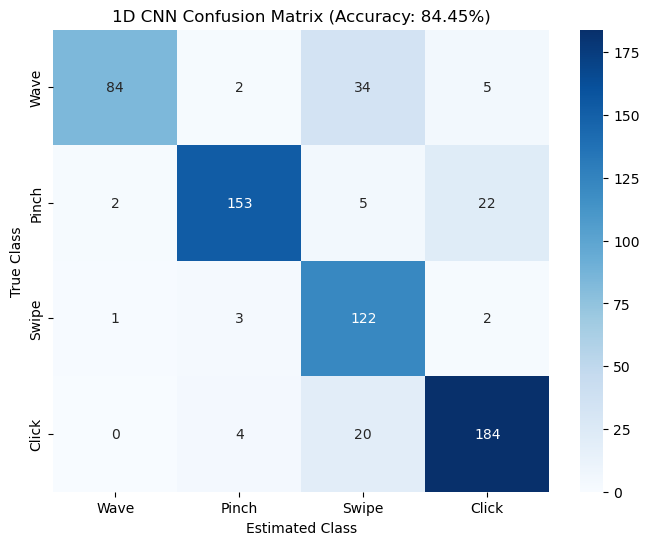

In [15]:
# Get class names for plotting
class_names = gesture_map_labels.keys()

# --- Print Classification Report ---
print("\n--- 1D CNN Classification Report ---")
y_pred_probs = cnn_model.predict(X_test_cnn)
y_pred_cnn = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test, y_pred_cnn, target_names=class_names))

print("*-" * 50)

# --- Plot Confusion Matrix ---
print("--- 1D CNN Confusion Matrix ---")
cm_cnn = confusion_matrix(y_test, y_pred_cnn)

plt.figure(figsize=(8, 6))
sn.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'1D CNN Confusion Matrix (Accuracy: {accuracy*100:.2f}%)')
plt.ylabel('True Class')
plt.xlabel('Estimated Class')
plt.show()

## KNN:


--- Training k-Nearest Neighbors (k-NN) Model ---
Test Accuracy (k-NN, k=7): 88.65%
              precision    recall  f1-score   support

        Wave       0.92      0.82      0.86       125
       Pinch       0.84      0.96      0.90       182
       Swipe       0.89      0.82      0.85       128
       Click       0.92      0.90      0.91       208

    accuracy                           0.89       643
   macro avg       0.89      0.88      0.88       643
weighted avg       0.89      0.89      0.89       643



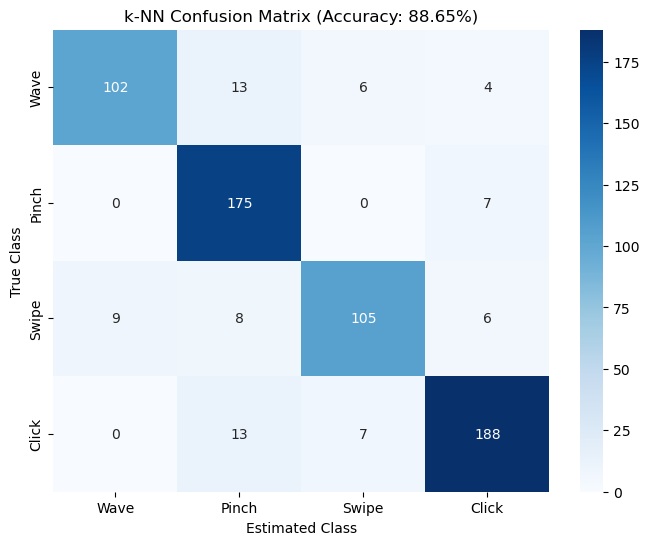

In [16]:
print("\n--- Training k-Nearest Neighbors (k-NN) Model ---")
# The paper used k=7 
knn_model = KNeighborsClassifier(n_neighbors=7)

# Training the model
knn_model.fit(X_train_scaled, y_train)

# --- Evaluating k-NN Model ---
y_pred_knn = knn_model.predict(X_test_scaled)
knn_accuracy = accuracy_score(y_test, y_pred_knn)
print(f"Test Accuracy (k-NN, k=7): {knn_accuracy * 100:.2f}%")

# --- Classification report ---
print(classification_report(y_test, y_pred_knn, target_names=class_names))

# --- Plot k-NN Confusion Matrix ---
cm_knn = confusion_matrix(y_test, y_pred_knn)
class_names = gesture_map_labels.keys()
plt.figure(figsize=(8, 6))
sn.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'k-NN Confusion Matrix (Accuracy: {knn_accuracy*100:.2f}%)')
plt.ylabel('True Class')
plt.xlabel('Estimated Class')
plt.show()

## Quadratic SVM Model:


--- Training (Recommended) Quadratic SVM Model ---
The paper found this was the best classifier (95.2% accuracy).
Test Accuracy (Quadratic SVM): 83.05%
              precision    recall  f1-score   support

        Wave       0.99      0.75      0.85       125
       Pinch       0.76      0.93      0.84       182
       Swipe       0.89      0.70      0.78       128
       Click       0.81      0.88      0.84       208

    accuracy                           0.83       643
   macro avg       0.86      0.81      0.83       643
weighted avg       0.85      0.83      0.83       643



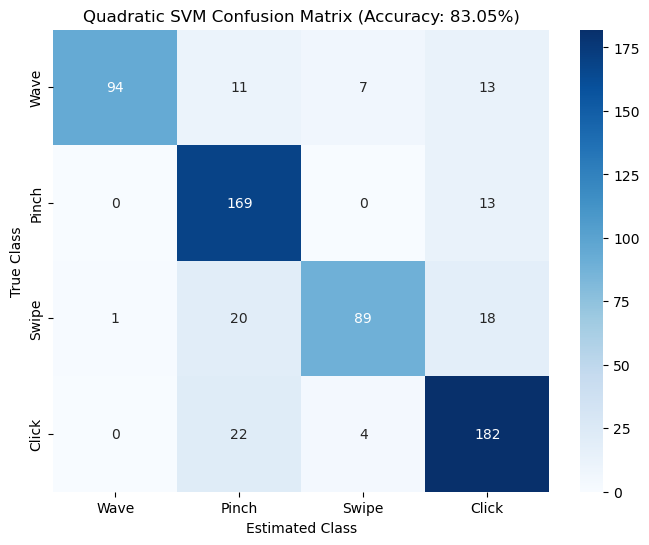

In [17]:
print("\n--- Training (Recommended) Quadratic SVM Model ---")
print("The paper found this was the best classifier (95.2% accuracy).")

# 'poly' with degree=2 is a quadratic kernel (from paper).
svm_model = SVC(kernel='poly', degree=2, C=1.0) 

# Train the model
svm_model.fit(X_train_scaled, y_train)

# --- Evaluate SVM Model ---
y_pred_svm = svm_model.predict(X_test_scaled)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"Test Accuracy (Quadratic SVM): {svm_accuracy * 100:.2f}%")

# --- Classification report ---
print(classification_report(y_test, y_pred_svm, target_names=class_names))

# --- Plot SVM Confusion Matrix ---
cm_svm = confusion_matrix(y_test, y_pred_svm)
class_names = gesture_map_labels.keys()
plt.figure(figsize=(8, 6))
sn.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Quadratic SVM Confusion Matrix (Accuracy: {svm_accuracy*100:.2f}%)')
plt.ylabel('True Class')
plt.xlabel('Estimated Class')
plt.show()

## 2nd Classification Method: Micro-Doppler Signature Envelopes

We use the same imports for this method as the first on. 

**!Important: For this part make sure that the training data provided with the project are placed on the same directory as this notebook.**

**Preprocessing and Feature extraction**

In [ ]:
def preprocess_spectrogram(df):#if the entire column is NaNs, we drop it, otherwise we replace the NaNs with the mean of the column
    #first we drop the columns with only NaNs
    df = df.dropna(axis=1, how='all')
    # Convert to numeric array
    matrix = df.to_numpy(dtype=float)            
    freqs = df.columns.to_numpy(dtype=float) 
    
    # Replace any NaNs with mean of the column without the Nans
    if np.isnan(matrix).any():
      col_means = np.nanmean(matrix, axis=0)
      inds = np.where(np.isnan(matrix))
      matrix[np.where(np.isnan(matrix))] = np.take(np.nanmean(matrix, axis=0), inds[1])
    return matrix, freqs


def extract_envelopes(matrix, freqs, sigma_u= 0.00025, sigma_l= 0.00025):#based on paper we classify the hand gestures based on the envelopes of their micro doppler signature
    #Shape is (time, frequency)
    # Create a Boolean mask for positive frequencies
    N, K=matrix.shape #shape variables according to paper
    pos_mask = freqs >= 0#returns series of booleans
    neg_mask= freqs <0
    # Select columns where frequency is positive
    pos_half = matrix[:, pos_mask]
    neg_half = matrix[:, neg_mask] 
    f_neg=freqs[neg_mask] 
    f_pos=freqs[pos_mask] 
    
    # Eu and El
    EU = np.sum(pos_half**2, axis=1)   #sum from 0 to K/2 -1 of Spectogram squared for each time frame so axis 1
    EL = np.sum(neg_half**2, axis=1)   #sum from K/2 to K-1 of Spectogram squared
    TU = sigma_u * EU # we then scale the energy to define thresholds
    TL = sigma_l * EL
    #We use these thresholds to see which frequencies have a significant energy
    eU = []
    eL = []
    #freq where amplitude greater 
    for i in range(matrix.shape[0]):
        
        col_pos=pos_half[i,:]#we go through it for each time step
        col_neg=neg_half[i,:]

        #freq where amplitude greater than threshold
        above_thresh_pos=np.where(col_pos>=TU[i])[0]
        above_thresh_neg=np.where(np.abs(col_neg)>=TL[i])[0]

        if len(above_thresh_pos)>0:
            valid_freqs_pos=f_pos[above_thresh_pos]
            if valid_freqs_pos.size > 0:
                eU.append( np.max(valid_freqs_pos))# max values have the most influence
        if len(above_thresh_neg)>0:
            valid_freqs_neg=f_neg[above_thresh_neg]
            if valid_freqs_neg.size > 0:
                eL.append( np.min(valid_freqs_neg))
      
    return eU, eL

    
def build_feature_vector(eU, eL):
    return np.concatenate([eU, eL])

**Optimal sigma parameter for best feature extraction:**

In [ ]:
base_path='' #Make sure to add the path to where the training data is located
people = ['Person A', 'Person B', 'Person C', 'Person D', 'Person E', 'Person F']  
gestures = ['click', 'pinch', 'swipe', 'wave']


#test for different sigma parameters
sigma_list = [ 0.000525, 0.0005, 0.000475, 0.00045, 0.000425, 0.0004, 0.000375, 0.00035, 0.000325, 0.0003, 0.000275, 0.00025, 0.000225, 0.00020, 0.000175, 0.00015]
X_names=[0,1,2,3,4,5,6,7,8,9,10,11,12,13, 14, 15]
for name in X_names:
    globals()[f'X_sigma{name}'] = {}
    globals()[f'y_sigma{name}'] =[]
    

for sigma, name in zip(sigma_list, X_names):
    for person in people:
        for gesture in gestures:
            gesture_path = os.path.join(base_path, person, gesture)
            if os.path.exists(gesture_path):
                files = [f for f in os.listdir(gesture_path) if f.endswith('.csv')]
                dfs = []
                for f in files:
                    df = pd.read_csv(os.path.join(gesture_path, f), dtype=np.float32)
                    matrix, freqs = preprocess_spectrogram(df)
                    pos_env, neg_env = extract_envelopes(matrix, freqs, sigma, sigma)
                    features = build_feature_vector(pos_env, neg_env)
                    dfs.append(features)
                    globals()[f'y_sigma{name}'].append(gesture)
                globals()[f'X_sigma{name}'][f'{person}_{gesture}'] = dfs


**Padding and scaling of different datasets to test for highest accuracy:**

In [ ]:
scaler=StandardScaler()
encoder= LabelEncoder()
Shuffle_state = 4720
#padding and scaling
for name in X_names:
    globals()[f'flat_X_sigma{name}'] = [vec for sublist in globals()[f'X_sigma{name}'].values() for vec in sublist]
    max_len = max(len(f) for f in globals()[f'flat_X_sigma{name}'])
    globals()[f'y_encoded{name}']=encoder.fit_transform(globals()[f'y_sigma{name}'])
    globals()[f'padded_X_sigma{name}'] = np.array([np.pad(f, (0, max_len - len(f)), 'constant') for f in globals()[f'flat_X_sigma{name}']])
    globals()[f'scaled_X_sigma{name}'] = scaler.fit_transform(globals()[f'padded_X_sigma{name}'])
    globals()[f'X_train_sigma{name}'], globals()[f'X_test_sigma{name}'],globals()[f'y_train_sigma{name}'], globals()[f'y_test_sigma{name}'] = train_test_split(globals()[f'scaled_X_sigma{name}'], globals()[f'y_encoded{name}'], test_size=0.2, stratify=globals()[f'y_encoded{name}'], random_state=Shuffle_state)

**KNN Feature Testing:**

In [ ]:
#knn feature testing 
n_neighbors=[1, 3 , 5, 7, 9, 11, 13, 15]# not too high to avoid overfitting, recommend sqrt of n which is 960/4
metrics=['euclidean', 'manhattan', 'chebyshev', 'minkowski']

accuracy=[]
best_accuracies=[]
for name in X_names:
    accuracy_list=[]
    for neighbor in n_neighbors:
        for metric in metrics:
                globals()[f'X_knn_sigma{name}'] = KNeighborsClassifier(n_neighbors=neighbor, metric=metric)#Knn model according to article
                globals()[f'X_knn_sigma{name}'].fit(globals()[f'X_train_sigma{name}'], globals()[f'y_train_sigma{name}'])
                globals()[f'y_pred_sigma{name}'] = (globals()[f'X_knn_sigma{name}']).predict(globals()[f'X_test_sigma{name}'])
                acc = accuracy_score(globals()[f'y_test_sigma{name}'], globals()[f'y_pred_sigma{name}'])
                accuracy_list.append((acc, neighbor, metric))
    accuracy.append(accuracy_list)
    best= max(accuracy_list, key=lambda x: x[0])
    best_accuracies.append(best[0])
    print(f" Sigma {name}: Best Accuracy = {best[0]:.4f} with k={best[1]}, metric='{best[2]}'")

In [ ]:
#Plot KNN accuracy vs. Sigma Value
plt.figure(figsize=(14, 5))
plt.plot(sigma_list, best_accuracies, marker='o', linestyle='-', color='teal')
plt.title("best KNN Accuracy vs. Sigma Value")
plt.xlabel("Sigma Value")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(sigma_list)
plt.tight_layout()
plt.show()

since the highest accuracy is obtained with the knn parameters: k=31, metric='manhattan', below is a plot of the evolution of the KNN accuracy depending on the sigma value. As can be seen, the accuracy is far more influences by the sigma value than the parameters, as the same parameters are almost always responsible for the same accuracies.

In [ ]:
# Fixed KNN parameters
k = 7
metric = 'euclidean'


# Store accuracy for each sigma
acc_vs_sigma = []

for name in X_names:
    model = KNeighborsClassifier(n_neighbors=k, metric=metric)
    model.fit(globals()[f'X_train_sigma{name}'], globals()[f'y_train_sigma{name}'])
    globals()[f'y_pred_sigma{name}'] = model.predict(globals()[f'X_test_sigma{name}'])
    acc = accuracy_score(globals()[f'y_test_sigma{name}'],  globals()[f'y_pred_sigma{name}'])
    acc_vs_sigma.append(acc)

# Plot
plt.figure(figsize=(18, 5))
plt.plot(sigma_list, acc_vs_sigma, marker='o', linestyle='-', color='darkorange')
plt.title(f"KNN Accuracy vs. Sigma (k={k}, metric='{metric}')")
plt.xlabel("Sigma Value")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xscale('log')  # Optional: log scale for better spacing
plt.xticks(sigma_list)
plt.tight_layout()
plt.show()

**Effect of the different KNN parameters for the sigma value for which the highest accuracy is obtained**

In [ ]:
results=[]
for neighbor in n_neighbors:
        for metric in metrics:
            X_knn_sigma14= KNeighborsClassifier(n_neighbors=neighbor, metric=metric)
            X_knn_sigma14.fit(X_train_sigma14, y_train_sigma14)
            y_pred_sigma14 = X_knn_sigma14.predict(X_test_sigma14)
            acc = accuracy_score(y_test_sigma14, y_pred_sigma14)
            results.append((neighbor, metric, acc))

df = pd.DataFrame(results, columns=['n_neighbors', 'metric', 'accuracy'])

plt.figure(figsize=(12, 6))
sn.barplot(data=df, x='metric', y='accuracy', hue='n_neighbors', errorbar=None)
plt.title("KNN Accuracy by Metric and Number of Neighbors")
plt.ylabel("Accuracy")
plt.xlabel("Distance Metric")
plt.legend(title="n_neighbors")
plt.tight_layout()
plt.show()

#Heatmap for fixed weights
pivot = df.pivot(index='n_neighbors', columns='metric', values='accuracy')


plt.figure(figsize=(8, 12))
sn.heatmap(pivot, annot=True, cmap='viridis')
plt.title("Accuracy Heatmap (weights='uniform')")
plt.ylabel("n_neighbors")
plt.xlabel("metric")
plt.tight_layout()
plt.show()

This confirms the parameters given in the paper as giving the highest accuracy, which is 70% and given with the metric 'manhattan' and k=3, this is given for a sigma value of 0.000225

In [ ]:
# Filter for n_neighbors = 3
df_7 = df[df['n_neighbors'] == 7]
print(df_7)
# Barplot for k=7
plt.figure(figsize=(10, 5))
sn.barplot(data=df_3, x='metric', y='accuracy', errorbar=None)
plt.title("KNN Accuracy for n_neighbors = 7")
plt.ylabel("Accuracy")
plt.xlabel("Distance Metric")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Model Accuracy per gesture**

In [ ]:
#model accuracy per gesture
report = classification_report(y_test_sigma14, y_pred_sigma14, output_dict=True)
df_report = pd.DataFrame(report).transpose()

df_report.iloc[:-3][['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title("Per-Class Performance Metrics")
plt.ylabel("Score")

plt.xticks(rotation=45)
plt.tight_layout()

In [ ]:
# Filter for n_neighbors = 3
df_7 = df[df['n_neighbors'] == 7]
print(df_7)
# Barplot for k=7
plt.figure(figsize=(10, 5))
sn.barplot(data=df_7, x='metric', y='accuracy', errorbar=None)
plt.title("KNN Accuracy for n_neighbors = 7")
plt.ylabel("Accuracy")
plt.xlabel("Distance Metric")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Now that we have confirmed the optimal sigma value sigma 11 or 0.00025, as it is the one that give the most consistent high result across all values we will create the database X with that value for future simplification

In [ ]:

X_knn = {}
y_knn=[]


for person in people:
    for gesture in gestures:
        gesture_path = os.path.join(person, person, gesture)
        if os.path.exists(gesture_path):
            files = [f for f in os.listdir(gesture_path) if f.endswith('.csv')]
            dfs = []
            for f in files:
                df = pd.read_csv(os.path.join(gesture_path, f), dtype=np.float32)
                matrix, freqs = preprocess_spectrogram(df)
                pos_env, neg_env = extract_envelopes(matrix, freqs)
                features = build_feature_vector(pos_env, neg_env)
                dfs.append(features)
                y_knn.append(gesture)
            X_knn[f'{person}_{gesture}'] = dfs 



In [ ]:
scaler= StandardScaler()
encoder=LabelEncoder()
#encode the gestures in y to be able to train the models
y_encoded_knn = encoder.fit_transform(y_knn)

flat_X_knn = [vec for sublist in X_knn.values() for vec in sublist]
max_len = max(len(f) for f in flat_X_knn)
X_padded_knn = np.array([np.pad(f, (0, max_len - len(f)), 'constant') for f in flat_X_knn])
scaler.fit(X_padded_knn)
X_scaled_knn=scaler.fit_transform(X_padded_knn)
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_scaled_knn, y_encoded_knn, test_size=0.2, stratify=y_knn)


**SVM:**

In [ ]:
#SVM
C_values=[0.01, 0.1, 1, 10, 100]
gamma_list=['scale', 'auto']
kernel_list=['linear', 'poly', 'rbf']
accuracy=[]
best_accuracies=[]
for name in X_names:
    accuracy_list=[]
    for kernel in kernel_list:
        for C in C_values:
            for gamma in gamma_list:
                    globals()[f'X_svm_sigma{name}'] = SVC(kernel = kernel, gamma = gamma, C=C)
                    globals()[f'X_svm_sigma{name}'].fit(globals()[f'X_train_sigma{name}'], globals()[f'y_train_sigma{name}'])
                    globals()[f'y_pred_sigma{name}'] = (globals()[f'X_knn_sigma{name}']).predict(globals()[f'X_test_sigma{name}'])
                    acc = accuracy_score(globals()[f'y_test_sigma{name}'], globals()[f'y_pred_sigma{name}'])
                    accuracy_list.append((acc, C, gamma, kernel))
    accuracy.append(accuracy_list)
    best= max(accuracy_list, key=lambda x: x[0])
    best_accuracies.append(best[0])
    print(f" Sigma {name}: Best Accuracy = {best[0]:.4f} with C={best[1]}, gamma={best[2]}, kernel={best[3]}")
            


In [ ]:
#Plot best SVM Accuracy vs. Sigma Value
plt.figure(figsize=(14, 5))
plt.plot(sigma_list, best_accuracies, marker='o', linestyle='-', color='teal')
plt.title("best SVM Accuracy vs. Sigma Value")
plt.xlabel("Sigma Value")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(sigma_list)
plt.tight_layout()
plt.show()

**Logistic Regression:**

In [ ]:
#logistic Regression

C_values=[0.01, 0.1, 1, 10, 100]
accuracy=[]
best_accuracies=[]
for name in X_names:
    accuracy_list=[]
    for C in C_values:
            globals()[f'X_log_sigma{name}'] = SVC(max_iter=int(1e6), C=C)
            globals()[f'X_log_sigma{name}'].fit(globals()[f'X_train_sigma{name}'], globals()[f'y_train_sigma{name}'])
            globals()[f'y_pred_sigma{name}'] = (globals()[f'X_knn_sigma{name}']).predict(globals()[f'X_test_sigma{name}'])
            acc = accuracy_score(globals()[f'y_test_sigma{name}'], globals()[f'y_pred_sigma{name}'])
            accuracy_list.append((acc, C))
    accuracy.append(accuracy_list)
    best= max(accuracy_list, key=lambda x: x[0])
    best_accuracies.append(best[0])
    print(f" Sigma {name}: Best Accuracy = {best[0]:.4f} with C={best[1]}")

In [ ]:
#Plot: best Logistic regression Accuracy vs. Sigma Value
plt.figure(figsize=(14, 5))
plt.plot(sigma_list, best_accuracies, marker='o', linestyle='-', color='teal')
plt.title("best Logistic regression Accuracy vs. Sigma Value")
plt.xlabel("Sigma Value")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(sigma_list)
plt.tight_layout()
plt.show()